In [19]:
%reload_ext autoreload
%autoreload 2

import os
from scipy.stats import truncnorm
import pickle

import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline   

from models_streams import *
from models_orbits import *
from priors import *
from utils import *
from mock_data import *
from likelihoods import *
from dynesty_fit import dynesty_fit
from corner_plots import *

In [20]:
q_mean, q_sig, nlive, sigma, N, seed = 1.0, 0.1, 4000, 5, 100, 41
PATH_SAVE  = f'/data/dc824-2/final_orbit_to_stream/q{q_mean}_qsig{q_sig}_seed{seed}_nlive{nlive}_sigma{sigma}'
id = 4
save_stream = f'{PATH_SAVE}/xx_{id+1:03d}'

with open(f'{save_stream}/dict_data.pkl', 'rb') as file:
        dict_data = pickle.load(file)
params_data = np.loadtxt(f'{save_stream}/params.txt')
theta_initial = dict_data['theta'][0]

In [21]:
model_info = {
    'model': gala_orbit_model_ndim12,
    'prior_transform': orbit_large_prior_transform_ndim12,
    'model_spline': orbit_spline,
    'log_likelihood': model_log_likelihood,
    'ndim': 12
}


In [22]:
nlive = 1000
dict_result = dynesty_fit(dict_data, 
                model_info['model'],
                model_info['model_spline'],
                model_info['log_likelihood'],
                model_info['prior_transform'],
                ndim=model_info['ndim'], nlive=nlive, theta_initial=theta_initial)
np.save( './best_q1.4', dict_result['samps'][np.argmax(dict_result['logl'])])

28123it [02:59, 157.04it/s, batch: 1 | bound: 6 | nc: 1 | ncall: 2068935 | eff(%):  1.309 | loglstar: -8.760 < -4.405 < -6.444 | logz: -23.450 +/-  0.131 | stop:  0.934]                


In [36]:
np.where( theta_model <= dict_data['theta'][-1])[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
   

In [34]:
dict_data['theta'][-1]

11.004300933824247

In [37]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(title='Flattening free')

# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

names = ['best_q0.8', 'best_qtrue', 'best_q1.0', 'best_q1.2', 'best_q1.4', 'best_q1.6']
colors = ['red', 'orange', 'purple', 'green', 'brown', 'yellow']
labels = ['q=0.8', 'True', 'q=1.0', 'q=1.2', 'q=1.4', 'q=1.6']
for i, name in enumerate(names):
    params = np.load(f'./{name}.npy')
    xyz_model, gamma, xyz_prog = model_info['model'](params, theta_initial=theta_initial)
    x_model, y_model, z_model = xyz_model[:, 0], xyz_model[:, 1], xyz_model[:, 2]
    theta_model = np.arctan2(y_model, x_model)
    theta_model[theta_model < 0] += 2*np.pi
    theta_model = np.unwrap(theta_model)

    arg_keep = np.where( theta_model <= dict_data['theta'][-1])[0]

    fig.add_trace(go.Scatter3d(
        x=xyz_model[arg_keep, 0], 
        y=xyz_model[arg_keep, 1], 
        z=xyz_model[arg_keep, 2], 
        mode='markers', 
        marker=dict(size=5, color=colors[i]),
        name=labels[i]
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()

### Fit for Data with ID 4 ###

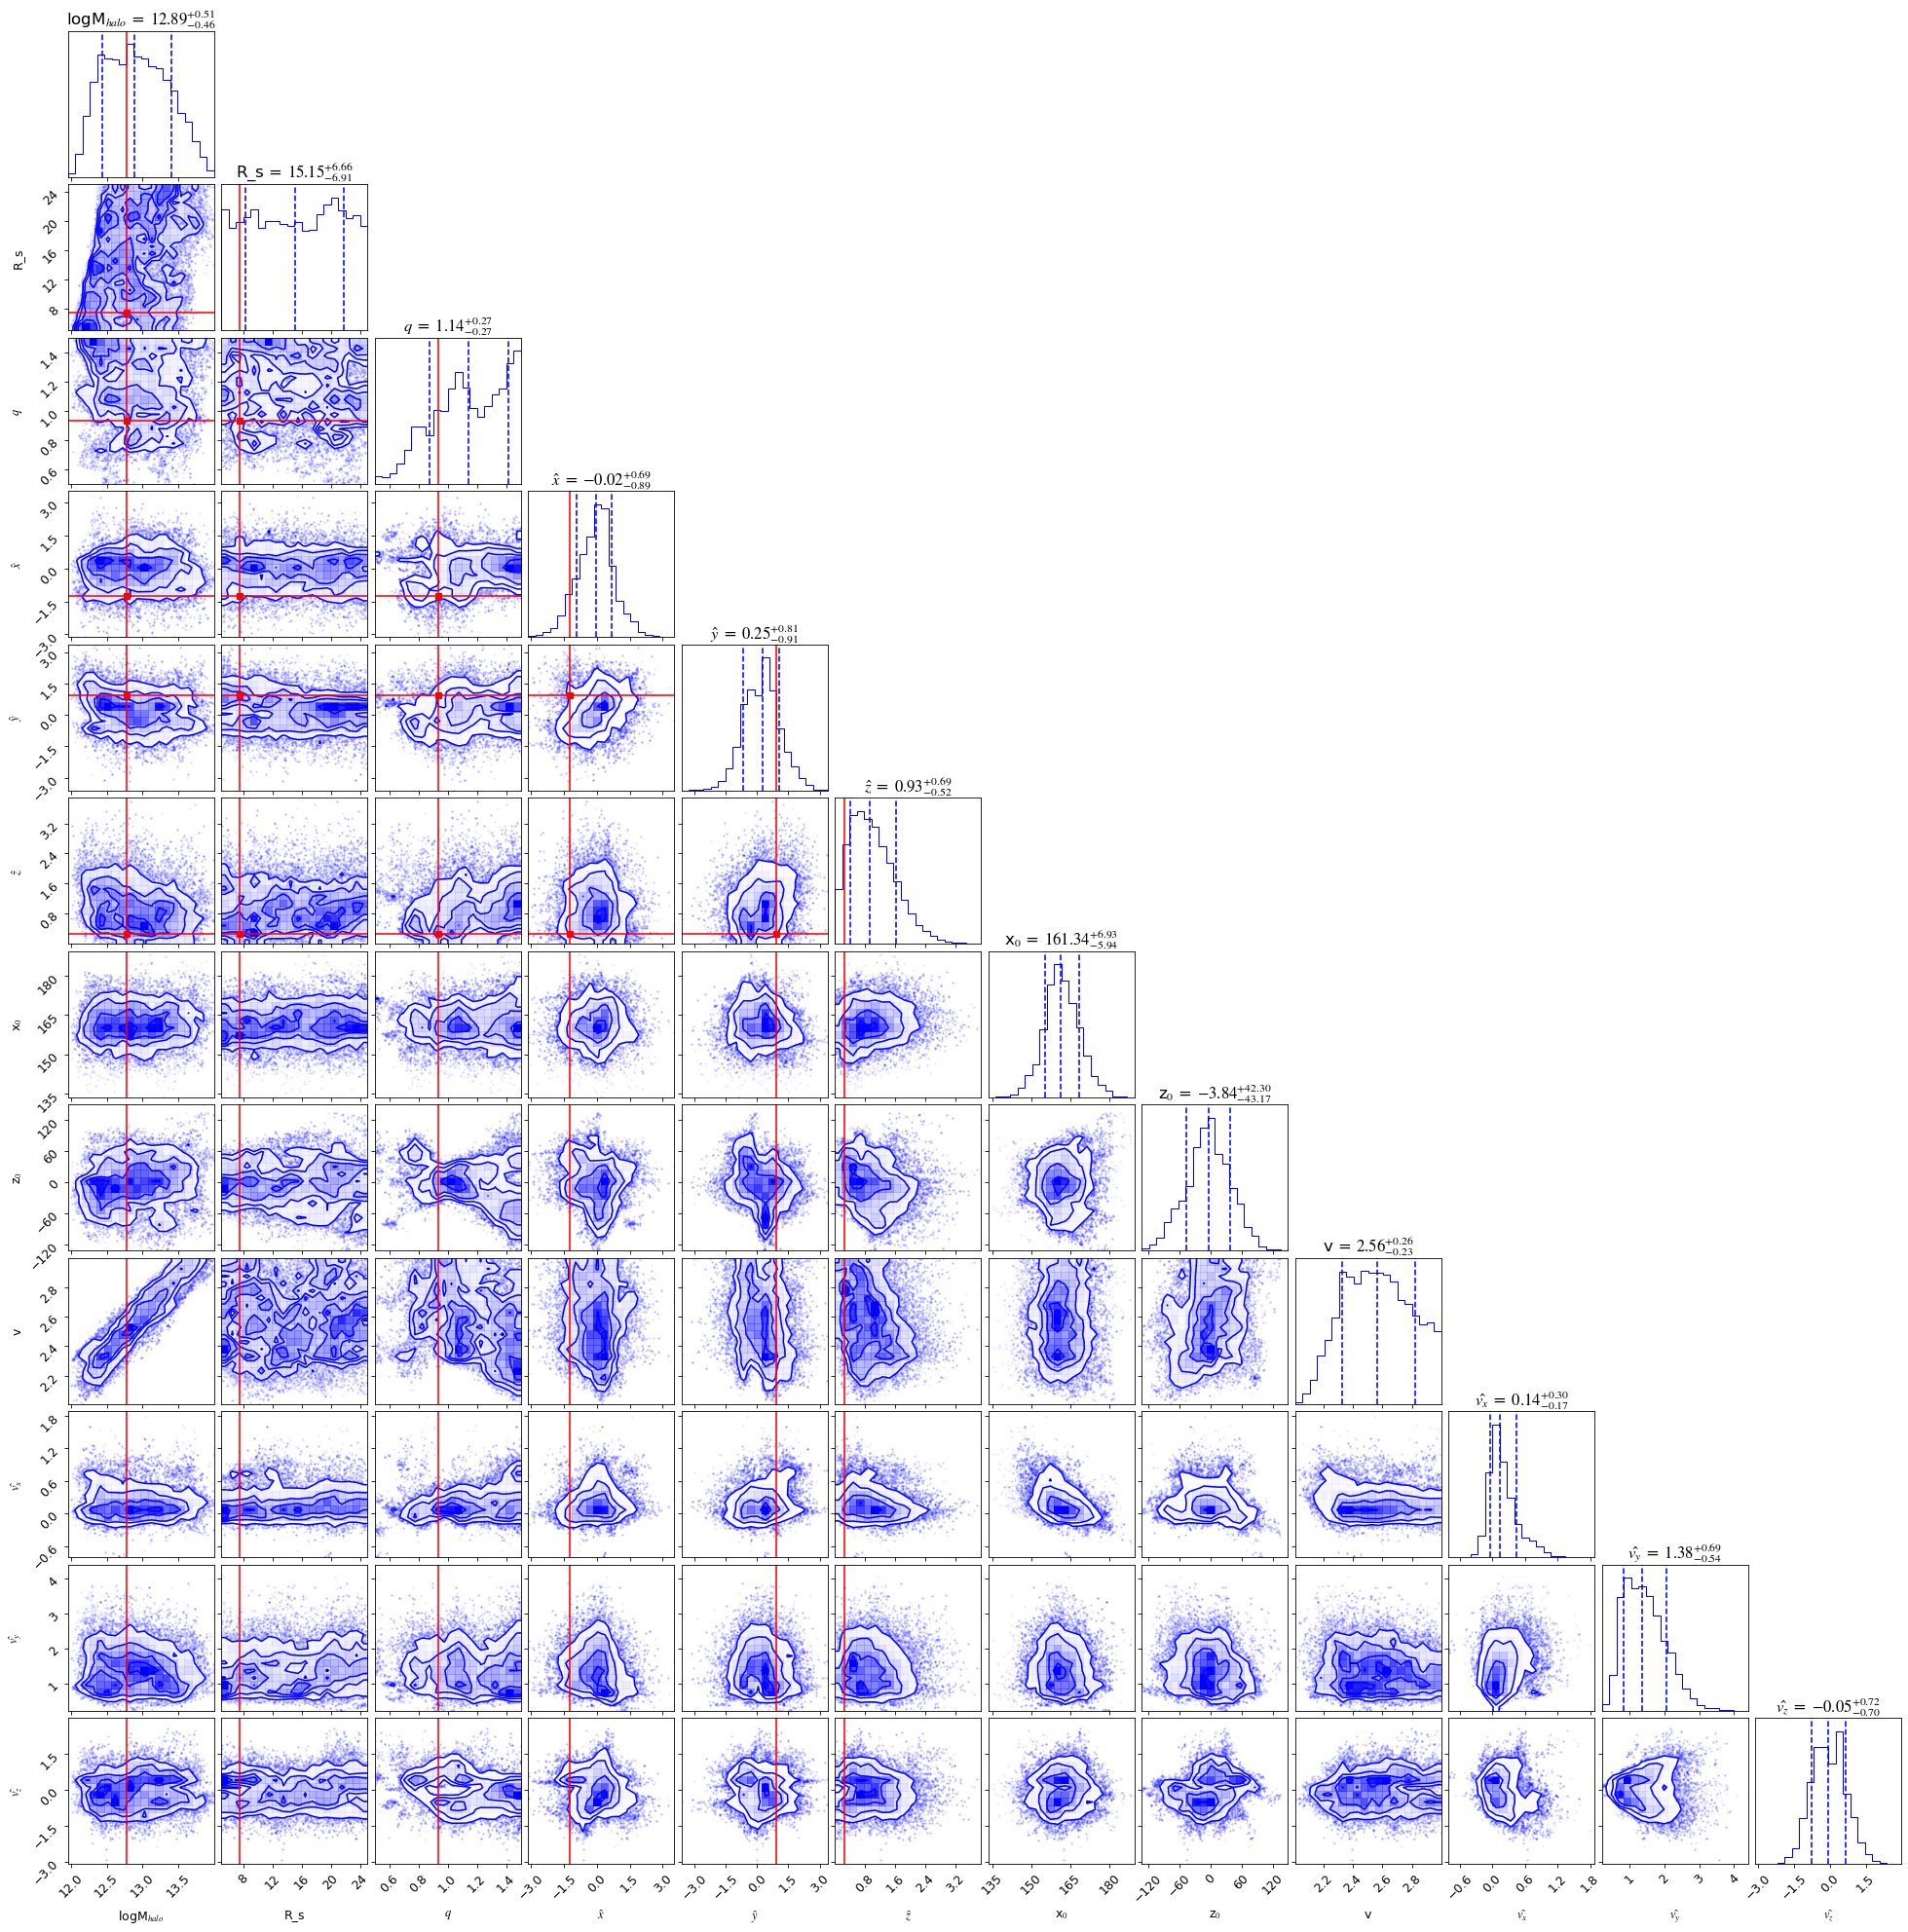

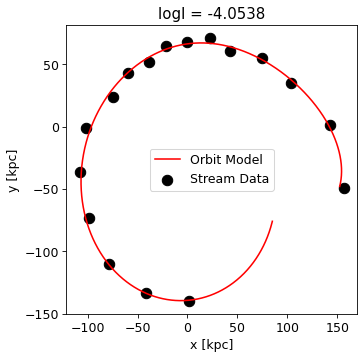

In [52]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
plt.title(f'logl = {np.max(dict_result["logl"]):.4f}')
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.update_layout(title='Flattening free')

# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

# Normalize the direction vector
d = params_data[3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='green', width=10),
    showlegend=False
))

xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
fig.add_trace(go.Scatter3d(
    x=xyz_model[:, 0], 
    y=xyz_model[:, 1], 
    z=xyz_model[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Best Fit Orbit'
))

# Normalize the direction vector
d = dict_result['samps'][np.argmax(dict_result['logl'])][3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='orange', width=10),
    showlegend=False
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()

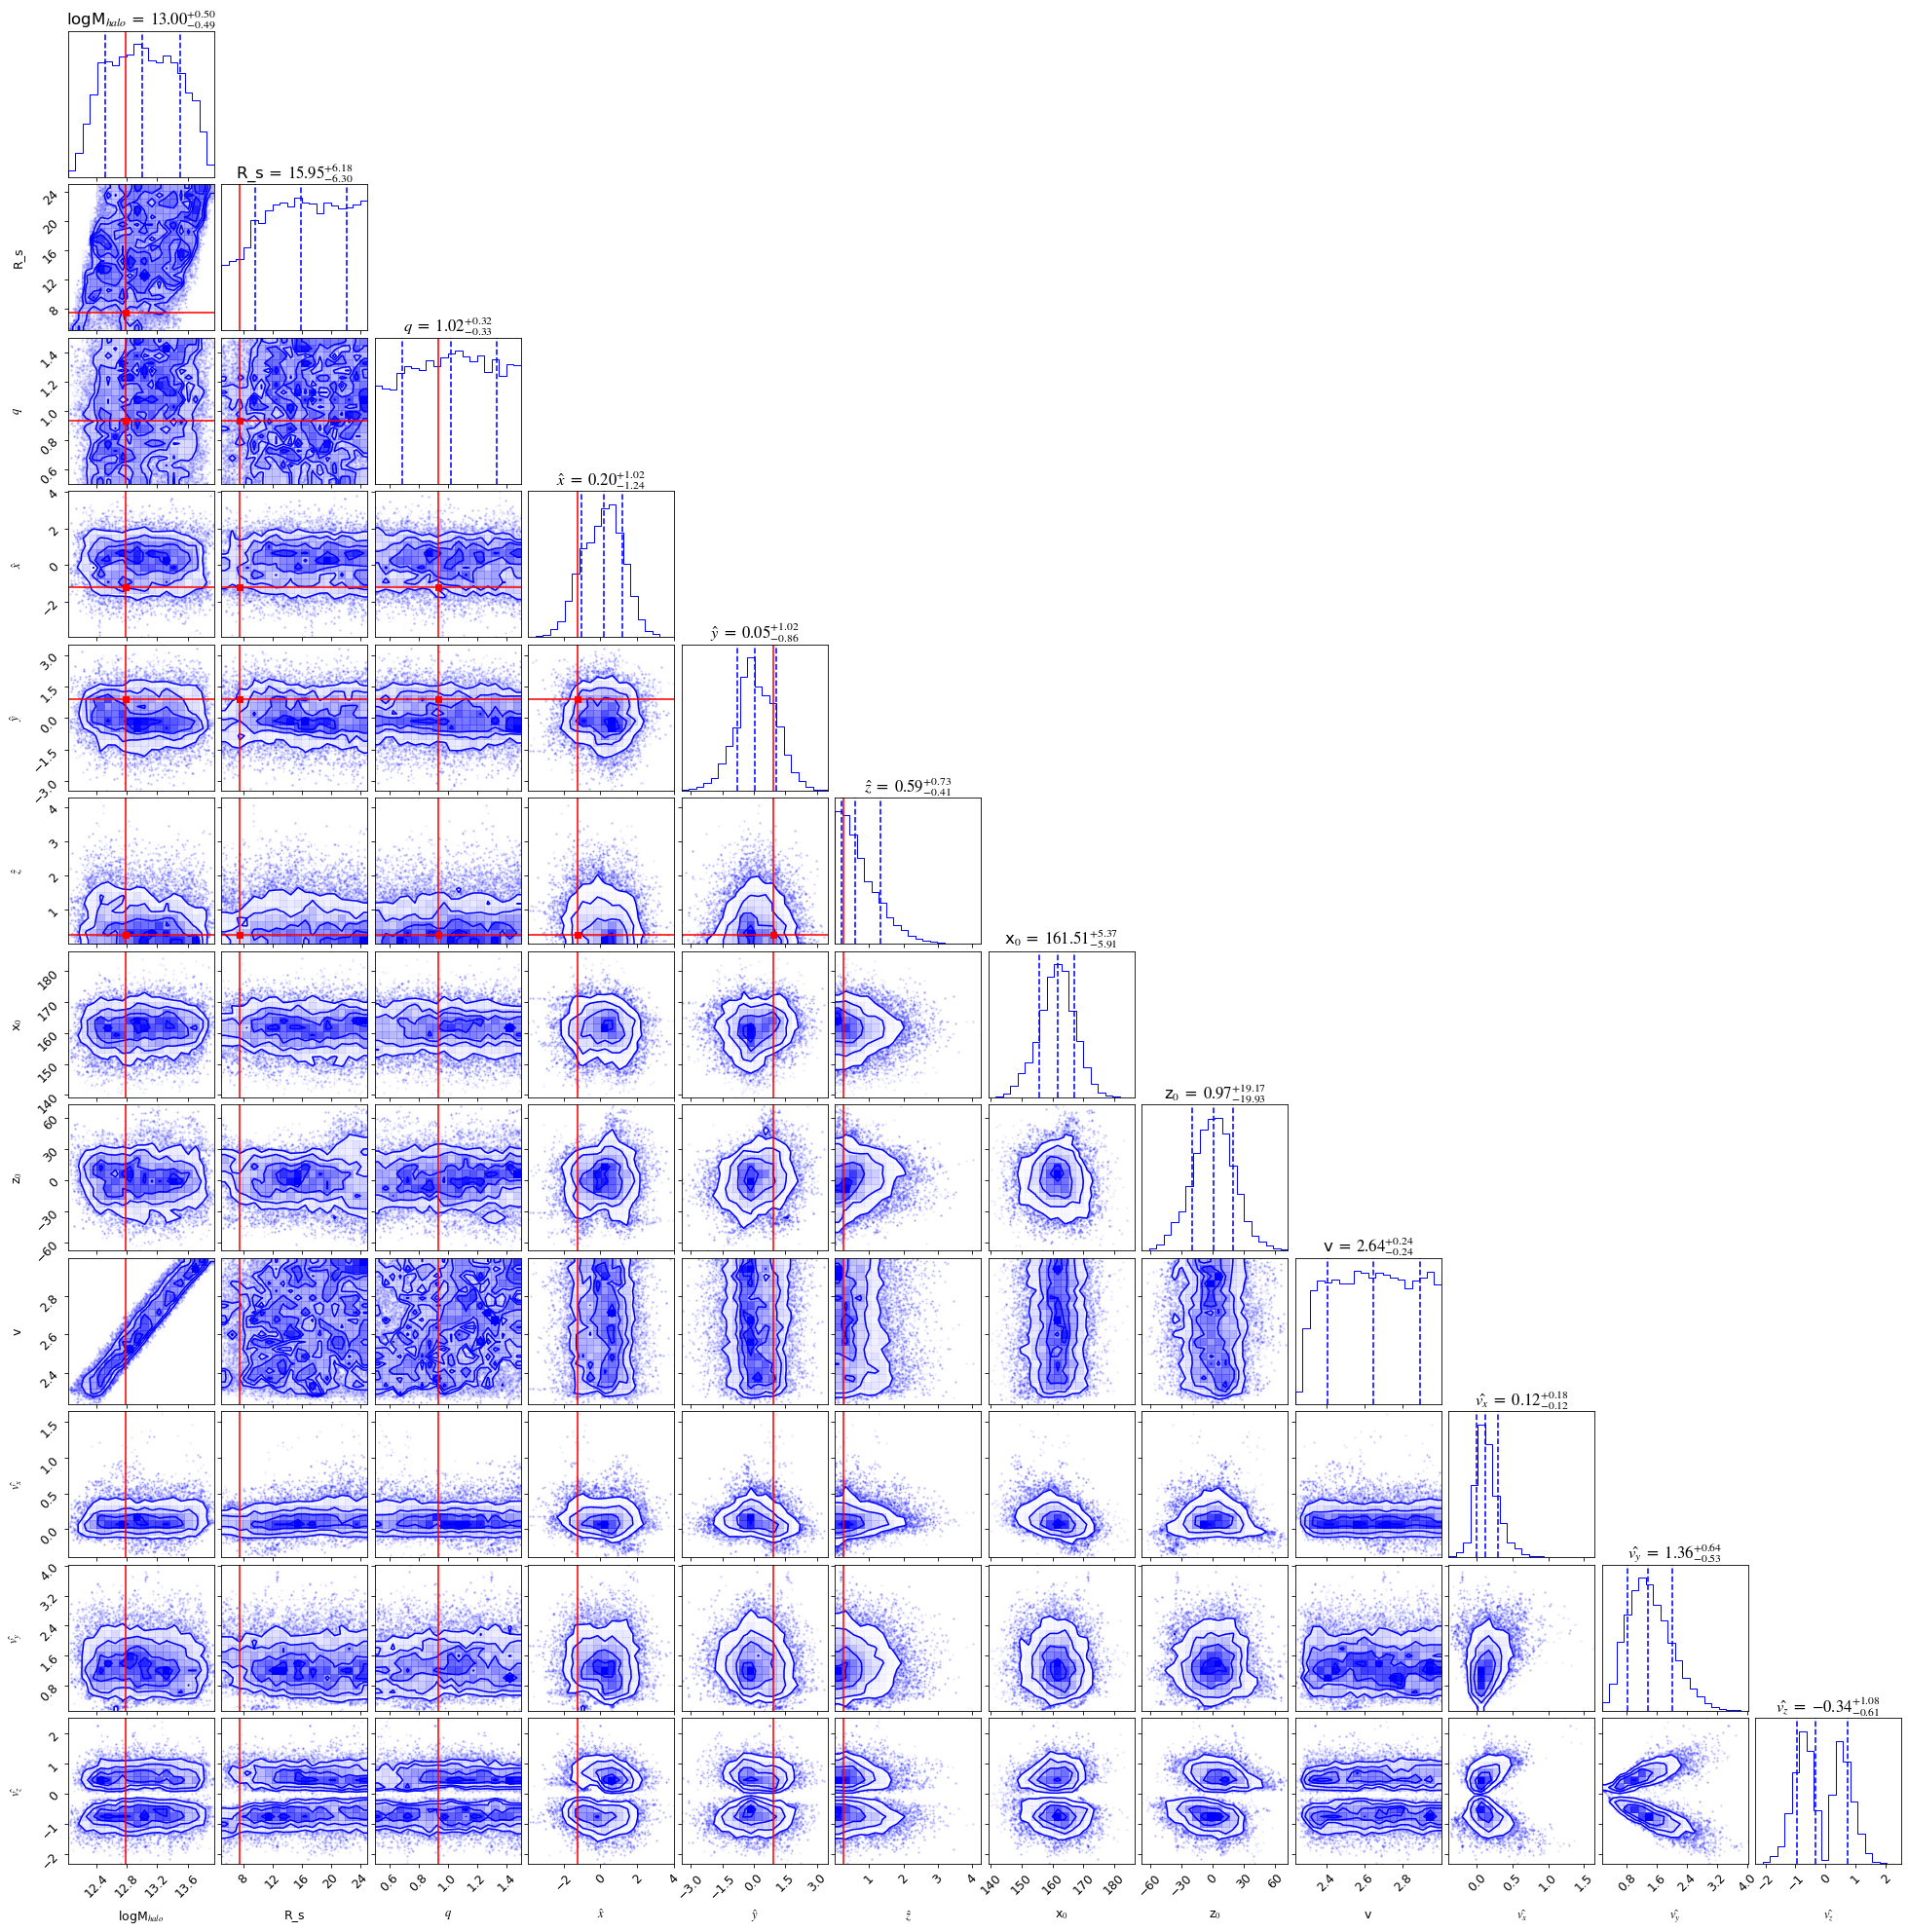

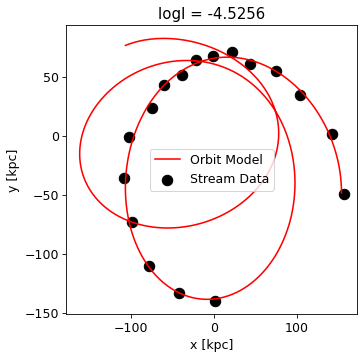

In [68]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
plt.title(f'logl = {np.max(dict_result["logl"]):.4f}')
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

In [70]:
import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(title='Fixed at correct flattening')
# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

# Normalize the direction vector
d = params_data[3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='green', width=10),
    showlegend=False
))

xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
fig.add_trace(go.Scatter3d(
    x=xyz_model[:, 0], 
    y=xyz_model[:, 1], 
    z=xyz_model[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Best Fit Orbit'
))

# Normalize the direction vector
d = dict_result['samps'][np.argmax(dict_result['logl'])][3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='orange', width=10),
    showlegend=False
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()

In [14]:
dict_result['samps'][np.argmax(dict_result['logl'])][2]

1.5983697214179868

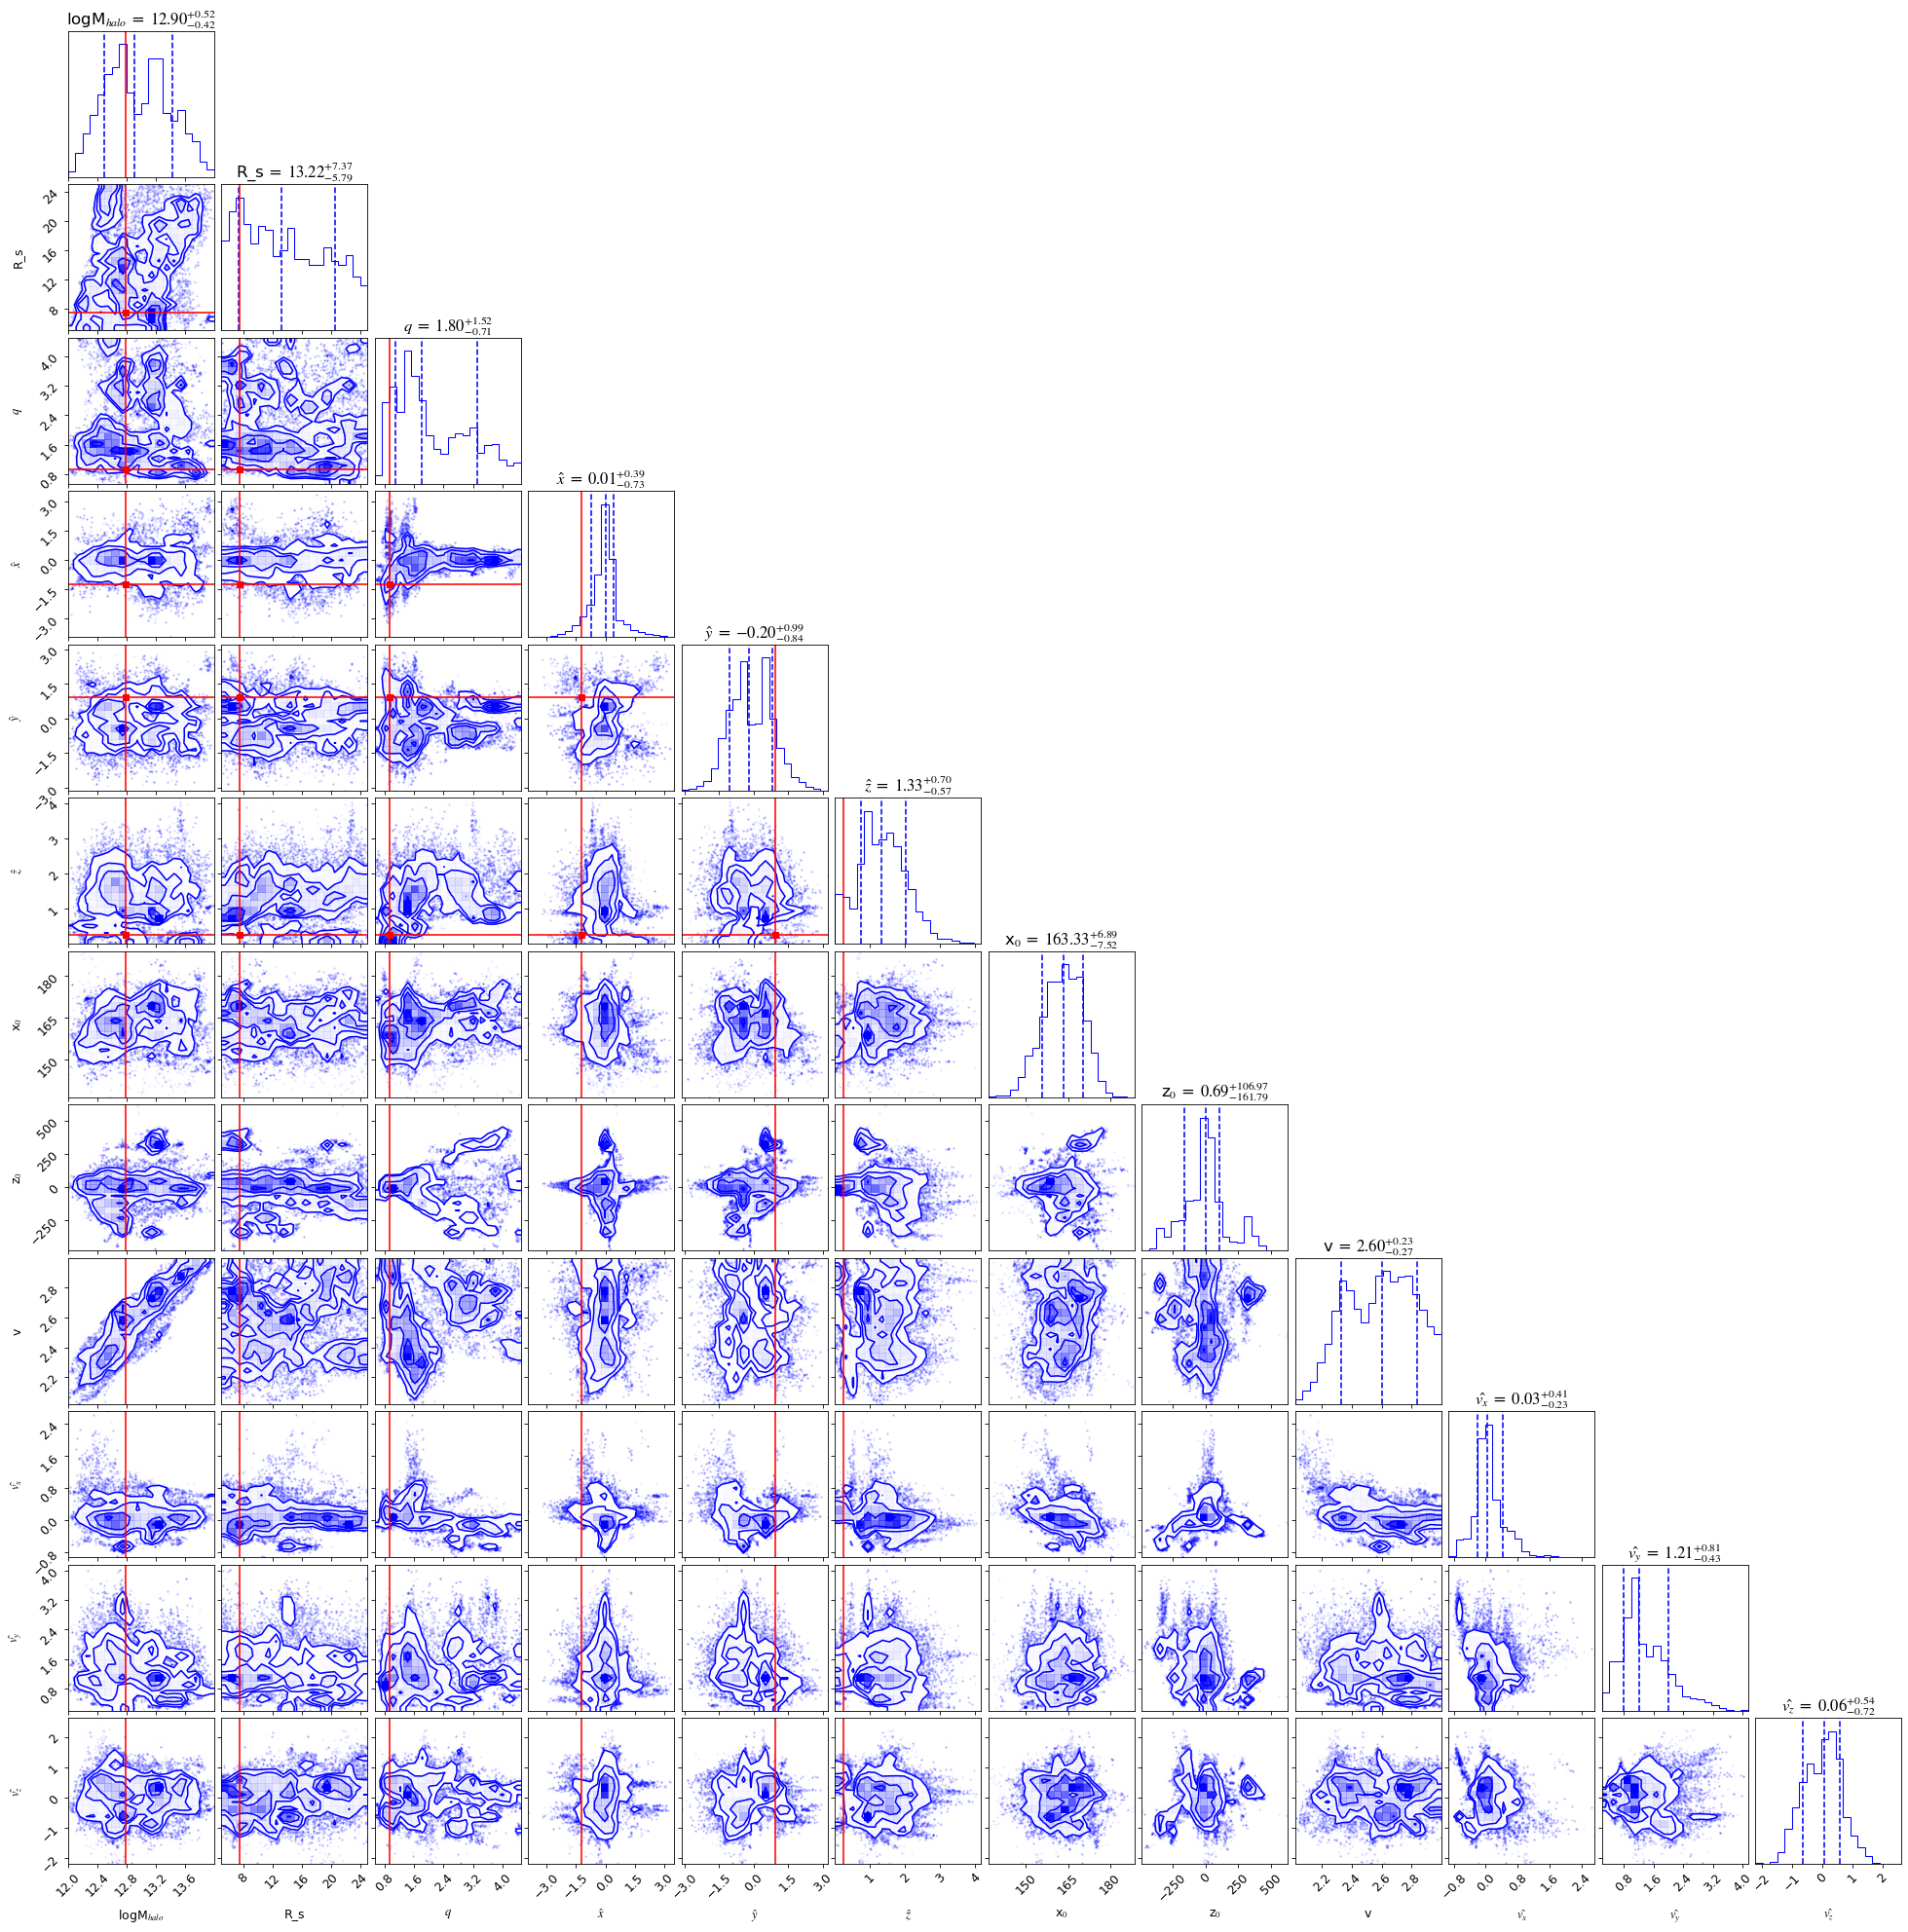

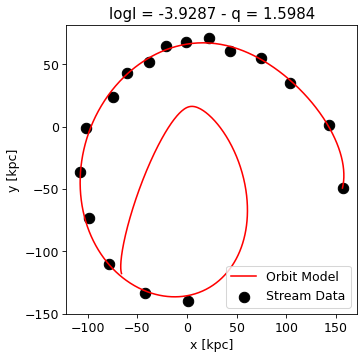

In [19]:
from corner_plots import *
labels=[r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$']
ground_truth = np.concatenate([params_data[:6], np.zeros(6)+np.nan])    

figure = corner.corner(dict_result['samps'], 
            labels=labels,
            color='blue',
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True, 
            title_kwargs={"fontsize": 16},
            truths=ground_truth, 
            truth_color='red')


plt.figure(figsize=(5, 5))
plt.xlabel(r'x [kpc]')
plt.ylabel(r'y [kpc]')
xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
plt.title(f"logl = {np.max(dict_result['logl']):.4f} - q = {dict_result['samps'][np.argmax(dict_result['logl'])][2]:.4f}")
x_model, y_model = xyz_model[:,0], xyz_model[:,1]
plt.plot(x_model, y_model, color='red', label='Orbit Model')
plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
plt.legend(loc='best')

In [7]:
import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(title='Free flattening up to 4')
# Plot the stream
xyz_stream, xyz_prog = gala_stream_model_ndim16(params_data)
fig.add_trace(go.Scatter3d(
    x=xyz_stream[:, 0], 
    y=xyz_stream[:, 1], 
    z=xyz_stream[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='blue'),
    name='Stream'
))

# Plot the final position of the progenitor on top
fig.add_trace(go.Scatter3d(
    x=[xyz_prog[0]], 
    y=[xyz_prog[1]], 
    z=[xyz_prog[2]], 
    mode='markers', 
    marker=dict(size=20, color='black'),
    name='Progenitor'
))

# Normalize the direction vector
d = params_data[3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='green', width=10),
    showlegend=False
))

xyz_model, xyz_prog = model_info['model'](dict_result['samps'][np.argmax(dict_result['logl'])], theta_initial=theta_initial)
fig.add_trace(go.Scatter3d(
    x=xyz_model[:, 0], 
    y=xyz_model[:, 1], 
    z=xyz_model[:, 2], 
    mode='markers', 
    marker=dict(size=5, color='red'),
    name='Best Fit Orbit'
))

# Normalize the direction vector
d = dict_result['samps'][np.argmax(dict_result['logl'])][3:6]
d_norm = np.linalg.norm(d)
if d_norm == 0:
    raise ValueError("Direction vector must be nonzero.")
d = d / d_norm

# Add a thick green line with orientation (dirx, diry, dirz)
fig.add_trace(go.Scatter3d(
    x=[-d[0] * 200, d[0] * 200], 
    y=[-d[1] * 200, d[1] * 200], 
    z=[-d[2] * 200, d[2] * 200], 
    mode='lines', 
    line=dict(color='orange', width=10),
    showlegend=False
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()